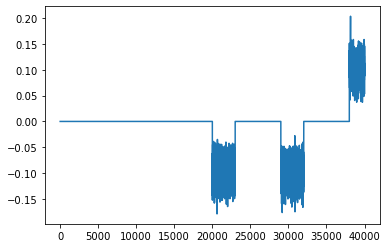

In [197]:
# Make 3 classes

import numpy as np
import matplotlib.pyplot as plt

dim = 40_000

cL = 0*np.array([
    [0.1,0.1,0.1],
    [0.1,0.1,0.1],
    [0.1,0.1,0.1]
])

cNL = 1*np.array([
    [0.1,0.0,0.0],
    [0.0,0.1,0.0],
    [0.0,0.0,0.1]
])

l_reg_sizes = np.array([
    [3000,2000,2000],
    [2000,3000,2000],
    [2000,2000,2000]
])

nl_reg_sizes = np.array([
    [3000,2000,2000],
    [2000,3000,2000],
    [2000,2000,2000]
])

lstart = 0
nlstart = 20000
c = np.zeros((2,3,dim))

l_size = 0
nl_size = 0
for i in range(3):
    for j in range(3):
        ls = l_reg_sizes[i,j]
        nls = nl_reg_sizes[i,j]
        c[0,i][lstart+l_size:lstart+l_size+ls] = cL[i,j]
        c[0,i][lstart+l_size:lstart+l_size+ls] *= (1+np.random.normal(0,0.2,ls))
        c[1,i][nlstart+nl_size:nlstart+nl_size+nls] = cNL[i,j]
        c[1,i][nlstart+nl_size:nlstart+nl_size+nls] *= (1+np.random.normal(0,0.2,nls))
        c[0,j][lstart+l_size:lstart+l_size+ls] = cL[i,j]
        c[0,j][lstart+l_size:lstart+l_size+ls] *= (1+np.random.normal(0,0.2,ls))
        c[1,j][nlstart+nl_size:nlstart+nl_size+nls] = cNL[i,j]
        c[1,j][nlstart+nl_size:nlstart+nl_size+nls] *= (1+np.random.normal(0,0.2,nls))
        l_size += ls
        nl_size += nls

# plt.plot(c[1,2])
# plt.plot(c[1,1])
plt.plot(c[1,2]-c[1,1]-c[1,0])
plt.show()

In [198]:
def instantiate(c, grp, pn, sigma):
    return c[0,grp] + (c[1,grp]*pn) + np.random.normal(0,sigma,size=c.shape[2])

nr = 120
nv = 180
nt = 180

sigma = 0.25

gr = []
gv = []
gt = []

for g,n in [(gr,nr), (gv,nv), (gt,nt)]:
    g.append(np.stack([instantiate(c, 0, 1, sigma) for _ in range(int(n/6))] + 
                      [instantiate(c, 0, -1, sigma) for _ in range(int(n/6))]))
    g.append(np.stack([instantiate(c, 1, 1, sigma) for _ in range(int(n/6))] + 
                      [instantiate(c, 1, -1, sigma) for _ in range(int(n/6))]))
    g.append(np.stack([instantiate(c, 2, 1, sigma) for _ in range(int(n/6))] + 
                      [instantiate(c, 2, -1, sigma) for _ in range(int(n/6))]))
    
gr = np.concatenate(gr)
gv = np.concatenate(gv)
gt = np.concatenate(gt)

for g in [gr, gv, gt]:
    print(g.shape)

(120, 40000)
(180, 40000)
(180, 40000)


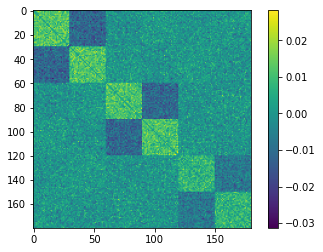

In [199]:
def mask(E):
    return (np.ones(E.shape[0])-np.eye(E.shape[0]))*E

plt.imshow(mask(np.corrcoef(gt)))
plt.colorbar()
plt.show()

In [180]:
br = np.repeat([[1,0,0]],nr/3,axis=0)
bv = np.repeat([[1,0,0]],nv/3,axis=0)
bt = np.repeat([[1,0,0]],nt/3,axis=0)

yr = np.concatenate([br, br[:,[1,0,2]], br[:,[1,2,0]]])
yv = np.concatenate([bv, bv[:,[1,0,2]], bv[:,[1,2,0]]])
yt = np.concatenate([bt, bt[:,[1,0,2]], bt[:,[1,2,0]]])

print(yr.shape)
print(yv.shape)
print(yt.shape)

(120, 3)
(180, 3)
(180, 3)


In [181]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500).fit(gr, np.argmax(yr, axis=1))
n = clf.predict(gt) == np.argmax(yt, axis=1)
print(np.sum(n)/yt.shape[0])

0.35555555555555557


In [182]:
rIdcs = np.arange(nr)
rvIdcs = np.arange(nr+nv)
vIdcs = np.arange(nr,nr+nv)
tIdcs = np.arange(nr+nv,nr+nv+nt)

print([min(rIdcs),max(rIdcs)])
print([min(rvIdcs),max(rvIdcs)])
print([min(vIdcs),max(vIdcs)])
print([min(tIdcs),max(tIdcs)])

[0, 119]
[0, 299]
[120, 299]
[300, 479]


In [183]:
import torch

X = torch.from_numpy(np.concatenate([gr, gv, gt])).unsqueeze(1).float().cuda()
y = torch.from_numpy(np.concatenate([yr, yv, yt])).float().cuda()

print(X.shape)
print(y.shape)

torch.Size([480, 1, 40000])
torch.Size([480, 3])


In [184]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGCNConv

ypred_gcn = []

def arith(n):
    return int(n*(n+1)/2)

class GCN(nn.Module):
    def __init__(self, nTgt, dp=0.5):
        super(GCN, self).__init__()
        self.gcn = []
        for i in range(2*nTgt):
            self.gcn.append(DenseGCNConv(dim,40).float().cuda())
            self.gcn.append(DenseGCNConv(40,3).float().cuda())
        self.gcn = nn.ModuleList(self.gcn)
        self.dp = nn.Dropout(p=dp)

    def forward(self, x):
        e = torch.ones(x.shape[0], x.shape[0]).float().cuda()/x.shape[0]
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            y = F.relu(self.gcn[2*i](x[:,i,:],e)).squeeze()
            y = self.gcn[2*i+1](y,e).squeeze()
            res.append(y)
        return res

class MLP(nn.Module):
    def __init__(self, nTgt, dp=0.5):
        super(MLP, self).__init__()
        self.lin = []
        for i in range(2*nTgt):
            self.lin.append(nn.Linear(dim,100).float().cuda())
            self.lin.append(nn.Linear(100,3).float().cuda())
        self.lin = nn.ModuleList(self.lin)
        self.dp = nn.Dropout(p=dp)

    def forward(self, x):
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            y = F.relu(self.lin[2*i](x[:,i,:])).squeeze()
            y = self.lin[2*i+1](y).squeeze()
            res.append(y)
        return res

def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res = model(X)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss, avg

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

nEpochs = 2000
pPeriod = 100
thresh = 0.0001

rmse = []

for i in range(1):
    validLoss = []

    gcn0 = MLP(1, 0.5)
    params = list(gcn0.parameters())
    optim = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-4)

    for epoch in range(nEpochs):
        optim.zero_grad()
        res = gcn0(X[rIdcs])
        avg = torch.mean(torch.stack(res), dim=0)
        loss0 = 0
        for r in res + [avg]:
            loss0 += ceLoss(r, y[rIdcs])/(len(res)+1)
        loss = torch.stack([loss0])
        loss += 100*torch.mean(torch.abs(gcn0.lin[0].weight))
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss[0]))}')
            lossV, _ = validate(gcn0, X[rvIdcs], y[rvIdcs], vIdcs)
            if len(validLoss) == 0 or lossV > max(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(gcn0.state_dict(), '../../Work/LatentSim/gcn.pyt')
    #                     finalRes[i] = Xt.grad.detach()
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break

    print('Finished training')

    gcn0.load_state_dict(torch.load('../../Work/LatentSim/gcn.pyt'))
    loss0, corr = validate(gcn0, X, y, tIdcs)
    ypred_gcn.append(corr.detach().cpu().numpy())

    rmse.append((float(loss0)))
    print(rmse[-1])
    
print('---')
print(np.mean(rmse))
print(np.std(rmse))

epoch 0 loss=1.361297369003296
New best validation epoch 0 loss=0.32777777314186096
epoch 100 loss=0.19871577620506287
New best validation epoch 100 loss=0.3888888955116272
epoch 200 loss=0.11795260012149811
epoch 300 loss=0.0789322778582573
epoch 400 loss=0.061149321496486664
epoch 500 loss=0.05162518098950386
epoch 600 loss=0.044937655329704285
epoch 700 loss=0.040514133870601654
epoch 800 loss=0.03688231483101845
epoch 900 loss=0.03400130942463875
epoch 1000 loss=0.031848736107349396
epoch 1100 loss=0.02976023219525814
epoch 1200 loss=0.027803992852568626
epoch 1300 loss=0.02616972289979458
epoch 1400 loss=0.024731937795877457
epoch 1500 loss=0.023837491869926453
epoch 1600 loss=0.02244832180440426
epoch 1700 loss=0.021776434034109116
epoch 1800 loss=0.02065354213118553
epoch 1900 loss=0.019765721634030342
epoch 1999 loss=0.019237039610743523
Finished training
0.3888888955116272
---
0.3888888955116272
0.0


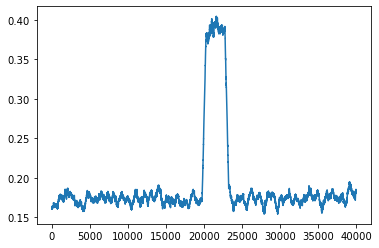

In [185]:
import matplotlib.pyplot as plt
from scipy.ndimage import filters

con_r1 = torch.einsum('ab,bc->bc',X[rIdcs][0:20].squeeze(),gcn0.lin[0].weight[:,:].T)
# con_r1 = torch.sum(torch.abs(gcn0.lin[0].weight[:,:].T), dim=1)
con_r1 = torch.sum(torch.abs(con_r1), dim=1)

ker = np.ones(500)/500

plt.plot(filters.convolve1d(con_r1.detach().cpu().numpy(), ker))
plt.show()

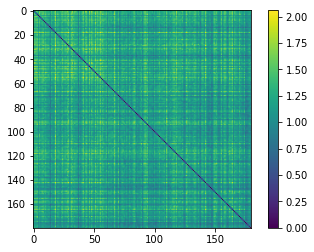

In [187]:
def mask(E):
    return (np.ones(E.shape[0])-np.eye(E.shape[0]))*E

D1 = torch.abs(X[tIdcs].squeeze()@gcn0.lin[0].weight[:,:].T)
D2 = torch.abs(X[tIdcs].squeeze()@gcn0.lin[0].weight[:,:].T)

E = D1@D2.T
plt.imshow(mask(E.detach().cpu().numpy()))
plt.colorbar()
plt.show()

In [189]:
import torch
import torch.nn as nn
import torch.nn.functional as F

rmse = []
ypred_sim = []

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class LatSim(nn.Module):
    def __init__(self, inp, dp=0.5, edp=0.1):
        super(LatSim, self).__init__()
        l = nn.Parameter(1e-4*torch.rand(inp.shape[-1],2).float().cuda())
        nl = nn.Parameter(1e-3*torch.rand(inp.shape[-1],100).float().cuda())
        self.active = nn.ParameterList([nl])
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
        self.l = 1
    
    def getLatentsAndEdges(self, x, i):
#         e = 1e-10
        y = torch.einsum('ac,ce->ae', x, self.active[i])
        e = y@y.T
        return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        x = self.dp(x)
        res = []
        es = []
        for i in range(1):
            _, _, e = self.getLatentsAndEdges(x[:,0,:], i)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.edp(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e, dim=1) 
            es.append(e)
            res.append(e@y)
        return res, es

def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss, avg.detach().cpu().numpy()

nEpochs = 500
pPeriod = 5
thresh = 0.1

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

for i in range(1):
    sim = LatSim(X, 0.5, 0.1) # 0.2 wrat, 0.1 other
    optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4)
    
    validLoss = []
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res, es = sim(X[rIdcs], y[rIdcs])
        avg = torch.mean(torch.stack(res), dim=0)
        loss = 0
        for r in res + [avg]:
            loss += ceLoss(r, y[rIdcs])
        loss = torch.stack([loss/(len(res)+1)])
#         loss += 100*torch.mean(torch.abs(es[0]))
        torch.sum(loss).backward()
        optim.step()
        sim.l = float(loss)
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss))}')
            lossV, _ = validate(sim, X[rvIdcs], y[rvIdcs], vIdcs)
            if len(validLoss) == 0 or lossV > max(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(sim.state_dict(), '../../Work/LatentSim/sim.pyt')
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break

    print('Finished training')

    sim.load_state_dict(torch.load('../../Work/LatentSim/sim.pyt'))
    loss, avg = validate(sim, X, y, tIdcs)
    ypred_sim.append(avg)
    rmse.append(loss.cpu().numpy())
    print(rmse[-1])

print('---')
print(np.mean(rmse))
print(np.std(rmse))

epoch 0 loss=1.0977848768234253
New best validation epoch 0 loss=0.3333333432674408
epoch 5 loss=0.7267592549324036
New best validation epoch 5 loss=0.6666666865348816
epoch 10 loss=0.5516175627708435
New best validation epoch 10 loss=0.6888889074325562
epoch 15 loss=0.5518521070480347
New best validation epoch 15 loss=0.75
epoch 20 loss=0.5514841079711914
New best validation epoch 20 loss=0.7611111402511597
epoch 25 loss=0.551445722579956
epoch 30 loss=0.5514448285102844
New best validation epoch 30 loss=0.7777777910232544
epoch 35 loss=0.5514451265335083
New best validation epoch 35 loss=0.7833333611488342
epoch 40 loss=0.5514457821846008
epoch 45 loss=0.5514451265335083
New best validation epoch 45 loss=0.7888889312744141
epoch 50 loss=0.5514456033706665
epoch 55 loss=0.5514452457427979
epoch 60 loss=0.5514454245567322
epoch 65 loss=0.5514457821846008
epoch 70 loss=0.5514454245567322
epoch 75 loss=0.5514447689056396
epoch 80 loss=0.5514448881149292
epoch 85 loss=0.5514447689056396
e

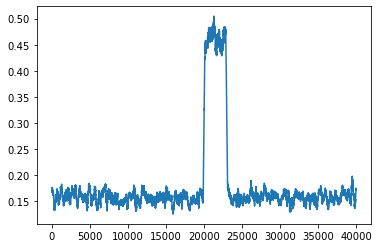

In [578]:
import matplotlib.pyplot as plt
from scipy.ndimage import filters

con_r1 = torch.einsum('ab,bc->bc',X[rIdcs][0:20].squeeze(),sim.active[0][:,:])
con_r1 = torch.sum(torch.abs(con_r1), dim=1)

ker = np.ones(200)/200

plt.plot(filters.convolve1d(con_r1.detach().cpu().numpy(), ker))
plt.show()

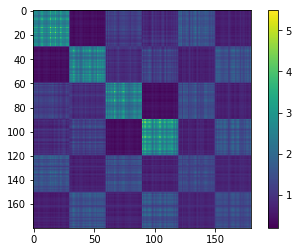

In [196]:
def mask(E):
    return (torch.ones(E.shape[0])-torch.eye(E.shape[0]))*E

D1 = (X[tIdcs].squeeze()@sim.active[0][:,:])
D2 = (X[tIdcs].squeeze()@sim.active[0][:,:])
# E = torch.softmax(D1.cpu()@D2.T.cpu()/10, dim=1)
E = torch.exp(D1.cpu()@D2.T.cpu()/4)
plt.imshow(E.detach().cpu().numpy())
plt.colorbar()
plt.show()

In [157]:
print(E)

tensor([[ 7.5484,  7.4496,  6.6397,  ...,  0.5267,  0.5365,  0.1754],
        [ 7.4496, 12.2002,  8.6503,  ...,  0.4434,  0.4261,  0.1225],
        [ 6.6397,  8.6503,  8.2852,  ...,  0.5597,  0.5100,  0.1789],
        ...,
        [ 0.5267,  0.4434,  0.5597,  ...,  1.5136,  1.3880,  2.2405],
        [ 0.5365,  0.4261,  0.5100,  ...,  1.3880,  1.4309,  2.1536],
        [ 0.1754,  0.1225,  0.1789,  ...,  2.2405,  2.1536,  7.1200]],
       grad_fn=<ExpBackward0>)


In [8]:
mu = torch.mean(X, dim=0, keepdim=True)
sg = torch.std(X, dim=0, keepdim=True)

X = (X - mu)/sg

print('Norm complete')

print(torch.min(X[:,0,420:422],dim=0))
print(torch.min(X[:,0,20420:20422],dim=0))

Norm complete
torch.return_types.min(
values=tensor([-3.3227, -2.7787], device='cuda:0'),
indices=tensor([62,  2], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7744, -3.1651], device='cuda:0'),
indices=tensor([342, 116], device='cuda:0'))
